In [ ]:
#|default_exp core

# Claudette's source

This is the 'literate' source code for Claudette. You can view the fully rendered version of the notebook [here](https://claudette.answer.ai/core.html), or you can clone the git repo and run the [interactive notebook](https://github.com/AnswerDotAI/claudette/blob/main/00_core.ipynb) in Jupyter. The notebook is converted the [Python module claudette/core.py](https://github.com/AnswerDotAI/claudette/blob/main/claudette/core.py) using [nbdev](https://nbdev.fast.ai/). The goal of this source code is to both create the Python module, and also to teach the reader *how* it is created, without assuming much existing knowledge about Claude's API.

Most of the time you'll see that we write some source code *first*, and then a description or discussion of it *afterwards*.

## Setup

In [ ]:
import os
# os.environ['ANTHROPIC_LOG'] = 'debug'

To print every HTTP request and response in full, uncomment the above line. This functionality is provided by Anthropic's SDK.

In [ ]:
#| export
import inspect, typing, mimetypes, base64, json
from collections import abc
try: from IPython import display
except: display=None

from anthropic import Anthropic, AnthropicBedrock, AnthropicVertex
from anthropic.types import Usage, TextBlock, Message, ToolUseBlock
from anthropic.resources import messages

import toolslm
from toolslm.funccall import *

from fastcore import imghdr
from fastcore.meta import delegates
from fastcore.utils import *

In [ ]:
#| hide
from nbdev import show_doc

In [ ]:
#| export
empty = inspect.Parameter.empty

:::{.callout-tip}

If you're reading the rendered version of this notebook, you'll see an "Exported source" collapsible widget below. If you're reading the source notebook directly, you'll see `#| exports` at the top of the cell. These show that this piece of code will be exported into the python module that this notebook creates. No other code will be included -- any other code in this notebook is just for demonstration, documentation, and testing.

You can toggle expanding/collapsing the source code of all exported sections by using the `</> Code` menu in the top right of the rendered notebook page.

:::

In [ ]:
#| exports

model_types = {
    # Anthropic
    'claude-3-opus-20240229': 'opus',
    'claude-3-5-sonnet-20240620': 'sonnet',
    'claude-3-haiku-20240307': 'haiku',
    # AWS
    'anthropic.claude-3-opus-20240229-v1:0': 'opus',
    'anthropic.claude-3-5-sonnet-20240620-v1:0': 'sonnet',
    'anthropic.claude-3-sonnet-20240229-v1:0': 'sonnet',
    'anthropic.claude-3-haiku-20240307-v1:0': 'haiku',
    # Google
    'claude-3-opus@20240229': 'opus',
    'claude-3-5-sonnet@20240620': 'sonnet',
    'claude-3-sonnet@20240229': 'sonnet',
    'claude-3-haiku@20240307': 'haiku',
}

all_models = list(model_types)

In [ ]:
#| export
models, models_aws, models_goog = all_models[:3], all_models[3:7], all_models[7:]

These are the current versions and [prices](https://www.anthropic.com/pricing#anthropic-api) of Anthropic's models at the time of writing.

In [ ]:
model = models[1]

For examples, we'll use Sonnet 3.5, since it's awesome.

## Antropic SDK

In [ ]:
cli = Anthropic()

This is what Anthropic's SDK provides for interacting with Python. To use it, pass it a list of *messages*, with *content* and a *role*. The roles should alternate between *user* and *assistant*.

:::{.callout-tip}

After the code below you'll see an indented section with an orange vertical line on the left. This is used to show the *result* of running the code above. Because the code is running in a Jupyter Notebook, we don't have to use `print` to display results, we can just type the expression directly, as we do with `r` here.

:::

In [ ]:
m = {'role': 'user', 'content': "I'm Jeremy"}
r = cli.messages.create(messages=[m], model=model, max_tokens=100)
r

Hello Jeremy! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to talk about or any questions you have?

<details>

- id: `msg_018EAtA4mLHFpYLUMUsHqeRL`
- content: `[{'text': "Hello Jeremy! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to talk about or any questions you have?", 'type': 'text'}]`
- model: `claude-3-5-sonnet-20240620`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 10, 'output_tokens': 36}`

</details>

### Formatting output

That output is pretty long and hard to read, so let's clean it up. We'll start by pulling out the `Content` part of the message.
To do that, we're going to write our first function which will be included to the `claudette/core.py` module.

:::{.callout-tip}

This is the first exported public function or class we're creating (the previous export was of a variable). In the rendered version of the notebook for these you'll see 4 things, in this order (unless the symbol starts with a single `_`, which indicates it's *private*):

- The signature (with the symbol name as a heading, with a horizontal rule above)
- A table of paramater docs (if provided)
- The doc string (in italics).
- The source code (in a collapsible "Exported source" block)

After that, we generally provide a bit more detail on what we've created, and why, along with a sample usage.

:::

In [ ]:
#| exports
def find_block(r:abc.Mapping, # The message to look in
               blk_type:type=TextBlock  # The type of block to find
              ):
    "Find the first block of type `blk_type` in `r.content`."
    return first(o for o in r.content if isinstance(o,blk_type))

This makes it easier to grab the needed parts of Claude's responses, which can include multiple pieces of content. By default, we look for the first text block. That will generally have the content we want to display.

In [ ]:
find_block(r)

TextBlock(text="Hello Jeremy! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to talk about or any questions you have?", type='text')

In [ ]:
#| exports
def contents(r):
    "Helper to get the contents from Claude response `r`."
    blk = find_block(r)
    if not blk and r.content: blk = r.content[0]
    return blk.text.strip() if hasattr(blk,'text') else str(blk)

For display purposes, we often just want to show the text itself.

In [ ]:
contents(r)

"Hello Jeremy! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to talk about or any questions you have?"

In [ ]:
#| exports
@patch
def _repr_markdown_(self:(Message)):
    det = '\n- '.join(f'{k}: `{v}`' for k,v in self.model_dump().items())
    cts = re.sub(r'\$', '&#36;', contents(self))  # escape `$` for jupyter latex
    return f"""{cts}

<details>

- {det}

</details>"""

Jupyter looks for a `_repr_markdown_` method in displayed objects; we add this in order to display just the content text, and collapse full details into a hideable section. Note that `patch` is from [fastcore](https://fastcore.fast.ai/), and is used to add (or replace) functionality in an existing class. We pass the class(es) that we want to patch as type annotations to `self`. In this case, `_repr_markdown_` is being added to Anthropic's `Message` class, so when we display the message now we just see the contents, and the details are hidden away in a collapsible details block.

In [ ]:
r

Hello Jeremy! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to talk about or any questions you have?

<details>

- id: `msg_018EAtA4mLHFpYLUMUsHqeRL`
- content: `[{'text': "Hello Jeremy! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to talk about or any questions you have?", 'type': 'text'}]`
- model: `claude-3-5-sonnet-20240620`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 10, 'output_tokens': 36}`

</details>

One key part of the response is the `usage` key, which tells us how many tokens we used by returning a `Usage` object.

We'll add some helpers to make things a bit cleaner for creating and formatting these objects.

In [ ]:
r.usage

In: 10; Out: 36; Cache create: 0; Cache read: 0; Total: 46

In [ ]:
#| exports
def usage(inp=0, # input tokens
          out=0,  # Output tokens
          cache_create=0, # Cache creation tokens
          cache_read=0 # Cache read tokens
         ):
    "Slightly more concise version of `Usage`."
    return Usage(input_tokens=inp, output_tokens=out, cache_creation_input_tokens=cache_create, cache_read_input_tokens=cache_read)

The constructor provided by Anthropic is rather verbose, so we clean it up a bit, using a lowercase version of the name.

In [ ]:
usage(5)

In: 5; Out: 0; Cache create: 0; Cache read: 0; Total: 5

In [ ]:
#| exports
@patch(as_prop=True)
def total(self:Usage): return self.input_tokens+self.output_tokens+getattr(self, "cache_creation_input_tokens",0)+getattr(self, "cache_read_input_tokens",0)

Adding a `total` property to `Usage` makes it easier to see how many tokens we've used up altogether.

In [ ]:
usage(5,1).total

6

In [ ]:
#| exports
@patch
def __repr__(self:Usage): return f'In: {self.input_tokens}; Out: {self.output_tokens}; Cache create: {getattr(self, "cache_creation_input_tokens",0)}; Cache read: {getattr(self, "cache_read_input_tokens",0)}; Total: {self.total}'

In python, patching `__repr__` lets us change how an object is displayed. (More generally, methods starting and ending in `__` in Python are called `dunder` methods, and have some `magic` behavior -- such as, in this case, changing how an object is displayed.)

In [ ]:
usage(5)

In: 5; Out: 0; Cache create: 0; Cache read: 0; Total: 5

In [ ]:
#| exports
@patch
def __add__(self:Usage, b):
    "Add together each of `input_tokens` and `output_tokens`"
    return usage(self.input_tokens+b.input_tokens, self.output_tokens+b.output_tokens, getattr(self,'cache_creation_input_tokens',0)+getattr(b,'cache_creation_input_tokens',0), getattr(self,'cache_read_input_tokens',0)+getattr(b,'cache_read_input_tokens',0))

And, patching `__add__` lets `+` work on a `Usage` object.

In [ ]:
r.usage+r.usage

In: 20; Out: 72; Cache create: 0; Cache read: 0; Total: 92

### Creating messages

Creating correctly formatted `dict`s from scratch every time isn't very handy, so next up we'll add helpers for this.

In [ ]:
def mk_msg(content, role='user', **kw):
    return dict(role=role, content=content, **kw)

We make things a bit more convenient by writing a function to create a message for us.

:::{.callout-note}

You may have noticed that we didn't export the `mk_msg` function (i.e. there's no "Exported source" block around it). That's because we'll need more functionality in our final version than this version has -- so we'll be defining a more complete version later. Rather than refactoring/editing in notebooks, often it's helpful to simply gradually build up complexity by re-defining a symbol.

:::

In [ ]:
prompt = "I'm Jeremy"
m = mk_msg(prompt)
m

{'role': 'user', 'content': "I'm Jeremy"}

In [ ]:
r = cli.messages.create(messages=[m], model=model, max_tokens=100)
r

Hello Jeremy! It's nice to meet you. Is there anything I can help you with today?

<details>

- id: `msg_01LghdZYe8S92Kqv8tERZJZ4`
- content: `[{'text': "Hello Jeremy! It's nice to meet you. Is there anything I can help you with today?", 'type': 'text'}]`
- model: `claude-3-5-sonnet-20240620`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 10, 'output_tokens': 23}`

</details>

In [ ]:
#| exports
def mk_msgs(msgs:list, **kw):
    "Helper to set 'assistant' role on alternate messages."
    if isinstance(msgs,str): msgs=[msgs]
    return [mk_msg(o, ('user','assistant')[i%2], **kw) for i,o in enumerate(msgs)]

LLMs, including Claude, don't actually have state, but instead dialogs are created by passing back all previous prompts and responses every time. With Claude, they always alternate *user* and *assistant*. Therefore we create a function to make it easier to build up these dialog lists.

But to do so, we need to update `mk_msg` so that we can't only pass a `str` as `content`, but can also pass a `dict` or an object with a `content` attr, since these are both types of message that Claude can create. To do so, we check for a `content` key or attr, and use it if found.

In [ ]:
def mk_msg(content, role='user', **kw):
    "Helper to create a `dict` appropriate for a Claude message. `kw` are added as key/value pairs to the message"
    if hasattr(content, 'content'): content,role = content.content,content.role
    if isinstance(content, abc.Mapping): content=content['content']
    return dict(role=role, content=str(content), **kw)

In [ ]:
msgs = mk_msgs([prompt, r, 'I forgot my name. Can you remind me please?'])
msgs

[{'role': 'user', 'content': "I'm Jeremy"},
 {'role': 'assistant',
  'content': '[TextBlock(text="Hello Jeremy! It\'s nice to meet you. Is there anything I can help you with today?", type=\'text\')]'},
 {'role': 'user', 'content': 'I forgot my name. Can you remind me please?'}]

Now, if we pass this list of messages to Claude, the model treats it as a conversation to respond to.

In [ ]:
cli.messages.create(messages=msgs, model=model, max_tokens=200)

Of course! You told me earlier that your name is Jeremy.

<details>

- id: `msg_012xRJ2q3AgS8FU9qfYgfg8s`
- content: `[{'text': 'Of course! You told me earlier that your name is Jeremy.', 'type': 'text'}]`
- model: `claude-3-5-sonnet-20240620`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 58, 'output_tokens': 16}`

</details>

## Client

In [ ]:
#| exports
class Client:
    def __init__(self, model, cli=None, log=False):
        "Basic Anthropic messages client."
        self.model,self.use = model,usage()
        self.log = [] if log else None
        self.c = (cli or Anthropic(default_headers={'anthropic-beta': 'prompt-caching-2024-07-31'}))

We'll create a simple `Client` for `Anthropic` which tracks usage stores the model to use. We don't add any methods right away -- instead we'll use `patch` for that so we can add and document them incrementally.

In [ ]:
c = Client(model)
c.use

In: 0; Out: 0; Cache create: 0; Cache read: 0; Total: 0

In [ ]:
#| exports
@patch
def _r(self:Client, r:Message, prefill=''):
    "Store the result of the message and accrue total usage."
    if prefill:
        blk = find_block(r)
        blk.text = prefill + (blk.text or '')
    self.result = r
    self.use += r.usage
    self.stop_reason = r.stop_reason
    self.stop_sequence = r.stop_sequence
    return r

We use a `_` prefix on private methods, but we document them here in the interests of literate source code.

`_r` will be used each time we get a new result, to track usage and also to keep the result available for later.

In [ ]:
c._r(r)
c.use

In: 10; Out: 23; Cache create: 0; Cache read: 0; Total: 33

Whereas OpenAI's models use a `stream` parameter for streaming, Anthropic's use a separate method. We implement Anthropic's approach in a private method, and then use a `stream` parameter in `__call__` for consistency:

In [ ]:
#| exports
@patch
def _log(self:Client, final, prefill, msgs, maxtok=None, sp=None, temp=None, stream=None, stop=None, **kwargs):
    self._r(final, prefill)
    if self.log is not None: self.log.append({
        "msgs": msgs, "prefill": prefill, **kwargs,
        "msgs": msgs, "prefill": prefill, "maxtok": maxtok, "sp": sp, "temp": temp, "stream": stream, "stop": stop, **kwargs,
        "result": self.result, "use": self.use, "stop_reason": self.stop_reason, "stop_sequence": self.stop_sequence
    })
    return self.result

In [ ]:
#| exports
@patch
def _stream(self:Client, msgs:list, prefill='', **kwargs):
    with self.c.messages.stream(model=self.model, messages=mk_msgs(msgs), **kwargs) as s:
        if prefill: yield(prefill)
        yield from s.text_stream
        self._log(s.get_final_message(), prefill, msgs, **kwargs)

Claude supports adding an extra `assistant` message at the end, which contains the *prefill* -- i.e. the text we want Claude to assume the response starts with. However Claude doesn't actually repeat that in the response, so for convenience we add it.

In [ ]:
#| exports
@patch
def _precall(self:Client, msgs, prefill, stop, kwargs):
    pref = [prefill.strip()] if prefill else []
    if not isinstance(msgs,list): msgs = [msgs]
    if stop is not None:
        if not isinstance(stop, (list)): stop = [stop]
        kwargs["stop_sequences"] = stop
    msgs = mk_msgs(msgs+pref)
    return msgs

In [ ]:
@patch
@delegates(messages.Messages.create)
def __call__(self:Client,
             msgs:list, # List of messages in the dialog
             sp='', # The system prompt
             temp=0, # Temperature
             maxtok=4096, # Maximum tokens
             prefill='', # Optional prefill to pass to Claude as start of its response
             stream:bool=False, # Stream response?
             stop=None, # Stop sequence
             **kwargs):
    "Make a call to Claude."
    msgs = self._precall(msgs, prefill, stop, kwargs)
    if stream: return self._stream(msgs, prefill=prefill, max_tokens=maxtok, system=sp, temperature=temp, **kwargs)
    res = self.c.messages.create(
        model=self.model, messages=msgs, max_tokens=maxtok, system=sp, temperature=temp, **kwargs)
    return self._log(res, prefill, msgs, maxtok, sp, temp, stream=stream, **kwargs)

Defining `__call__` let's us use an object like a function (i.e it's *callable*). We use it as a small wrapper over `messages.create`. However we're not exporting this version just yet -- we have some additions we'll make in a moment...

In [ ]:
c = Client(model, log=True)
c.use

In: 0; Out: 0; Cache create: 0; Cache read: 0; Total: 0

In [ ]:
c.model = models[-1]

In [ ]:
c('Hi')

Hello! How can I assist you today?

<details>

- id: `msg_01Vq8eg9CF89UnfycQVFtqmq`
- content: `[{'text': 'Hello! How can I assist you today?', 'type': 'text'}]`
- model: `claude-3-haiku-20240307`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 8, 'output_tokens': 12, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

In [ ]:
c.use

In: 8; Out: 12; Cache create: 0; Cache read: 0; Total: 20

Let's try out *prefill*:

In [ ]:
q = "Concisely, what is the meaning of life?"
pref = 'According to Douglas Adams,'

In [ ]:
c(q, prefill=pref)

According to Douglas Adams,  "The answer to the ultimate question of life, the universe, and everything is 42."

<details>

- id: `msg_01VCUby6sd4Et55uXQY4ZETt`
- content: `[{'text': 'According to Douglas Adams,  "The answer to the ultimate question of life, the universe, and everything is 42."', 'type': 'text'}]`
- model: `claude-3-haiku-20240307`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 24, 'output_tokens': 23, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

We can pass `stream=True` to stream the response back incrementally:

In [ ]:
for o in c('Hi', stream=True): print(o, end='')

Hello! How can I assist you today?

In [ ]:
c.use

In: 40; Out: 47; Cache create: 0; Cache read: 0; Total: 87

In [ ]:
for o in c(q, prefill=pref, stream=True): print(o, end='')

According to Douglas Adams,  "The answer to the ultimate question of life, the universe, and everything is 42."

In [ ]:
c.use

In: 64; Out: 70; Cache create: 0; Cache read: 0; Total: 134

Pass a stop seauence if you want claude to stop generating text when it encounters it.


In [ ]:
c("Count from 1 to 10", stop="5")

1, 2, 3, 4,

<details>

- id: `msg_01138y1DUMSYgpXj9LTD5H5f`
- content: `[{'text': '1, 2, 3, 4, ', 'type': 'text'}]`
- model: `claude-3-haiku-20240307`
- role: `assistant`
- stop_reason: `stop_sequence`
- stop_sequence: `5`
- type: `message`
- usage: `{'input_tokens': 15, 'output_tokens': 14, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

This also works with streaming, and you can pass more than one stop sequence:

In [ ]:
for o in c("Count from 1 to 10", stop=["2", "yellow"], stream=True): print(o, end='')
print(c.stop_reason, c.stop_sequence)

1, stop_sequence 2


You can check the logs:

In [ ]:
c.log[-1]

{'msgs': [{'role': 'user', 'content': 'Count from 1 to 10'}],
 'prefill': '',
 'max_tokens': 4096,
 'system': '',
 'temperature': 0,
 'stop_sequences': ['2', 'yellow'],
 'maxtok': None,
 'sp': None,
 'temp': None,
 'stream': None,
 'stop': None,
 'result': Message(id='msg_01J2j6oTiLDUpjwVgcZXtCFq', content=[TextBlock(text='1, ', type='text')], model='claude-3-haiku-20240307', role='assistant', stop_reason='stop_sequence', stop_sequence='2', type='message', usage=In: 15; Out: 5; Cache create: 0; Cache read: 0; Total: 20),
 'use': In: 94; Out: 89; Cache create: 0; Cache read: 0; Total: 183,
 'stop_reason': 'stop_sequence',
 'stop_sequence': '2'}

## Tool use

Let's now add tool use (aka *function calling*).

In [ ]:
#| exports
def mk_tool_choice(choose:Union[str,bool,None])->dict:
    "Create a `tool_choice` dict that's 'auto' if `choose` is `None`, 'any' if it is True, or 'tool' otherwise"
    return {"type": "tool", "name": choose} if isinstance(choose,str) else {'type':'any'} if choose else {'type':'auto'}

In [ ]:
print(mk_tool_choice('sums'))
print(mk_tool_choice(True))
print(mk_tool_choice(None))

{'type': 'tool', 'name': 'sums'}
{'type': 'any'}
{'type': 'auto'}


Claude can be forced to use a particular tool, or select from a specific list of tools, or decide for itself when to use a tool. If you want to force a tool (or force choosing from a list), include a `tool_choice` param with a dict from `mk_tool_choice`.

For testing, we need a function that Claude can call; we'll write a simple function that adds numbers together, and will tell us when it's being called:

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
sp = "You are a summing expert."

Claudette can autogenerate a schema thanks to the `toolslm` library. We'll force the use of the tool using the function we created earlier.

In [ ]:
tools=[get_schema(sums)]
choice = mk_tool_choice('sums')

We'll start a dialog with Claude now. We'll store the messages of our dialog in `msgs`. The first message will be our prompt `pr`, and we'll pass our `tools` schema.

In [ ]:
msgs = mk_msgs(pr)
r = c(msgs, sp=sp, tools=tools, tool_choice=choice)
r

ToolUseBlock(id='toolu_01PvSZwWLettTqoiVmPC1Tpv', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: `msg_01Nq1jdWSdEz5UKQbvrMGUJB`
- content: `[{'id': 'toolu_01PvSZwWLettTqoiVmPC1Tpv', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-3-haiku-20240307`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 493, 'output_tokens': 53, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

When Claude decides that it should use a tool, it passes back a `ToolUseBlock` with the name of the tool to call, and the params to use.

We don't want to allow it to call just any possible function (that would be a security disaster!) so we create a *namespace* -- that is, a dictionary of allowable function names to call.

In [ ]:
#| exports
def _mk_ns(*funcs:list[callable]) -> dict[str,callable]:
    "Create a `dict` of name to function in `funcs`, to use as a namespace"
    return {f.__name__:f for f in funcs}

In [ ]:
ns = _mk_ns(sums)
ns

{'sums': <function __main__.sums(a: int, b: int = 1) -> int>}

In [ ]:
#| exports
def call_func(fc:ToolUseBlock, # Tool use block from Claude's message
              ns:Optional[abc.Mapping]=None, # Namespace to search for tools, defaults to `globals()`
              obj:Optional=None # Object to search for tools
             ):
    "Call the function in the tool response `tr`, using namespace `ns`."
    if ns is None: ns=globals()
    if not isinstance(ns, abc.Mapping): ns = _mk_ns(*ns)
    func = getattr(obj, fc.name, None)
    if not func: func = ns[fc.name]
    res = func(**fc.input)
    return res

def mk_funcres(tuid, res):
    "Given tool use id and the tool result, create a tool_result response."
    return dict(type="tool_result", tool_use_id=tuid, content=res)

We can now use the function requested by Claude. We look it up in `ns`, and pass in the provided parameters.

In [ ]:
fc = find_block(r, ToolUseBlock)
res = mk_funcres(fc.id, call_func(fc, ns=ns))
res

Finding the sum of 604542 and 6458932


{'type': 'tool_result',
 'tool_use_id': 'toolu_01PvSZwWLettTqoiVmPC1Tpv',
 'content': 7063474}

In [ ]:
#| exports
def mk_toolres(
    r:abc.Mapping, # Tool use request response from Claude
    ns:Optional[abc.Mapping]=None, # Namespace to search for tools
    obj:Optional=None # Class to search for tools
    ):
    "Create a `tool_result` message from response `r`."
    cts = getattr(r, 'content', [])
    res = [mk_msg(r)]
    tcs = [mk_funcres(o.id, call_func(o, ns=ns, obj=obj)) for o in cts if isinstance(o,ToolUseBlock)]
    if tcs: res.append(mk_msg(tcs))
    return res

In order to tell Claude the result of the tool call, we pass back the tool use assistant request and the `tool_result` response.

In [ ]:
tr = mk_toolres(r, ns=ns)
tr

Finding the sum of 604542 and 6458932


[{'role': 'assistant',
  'content': "[ToolUseBlock(id='toolu_01PvSZwWLettTqoiVmPC1Tpv', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')]"},
 {'role': 'user',
  'content': "[{'type': 'tool_result', 'tool_use_id': 'toolu_01PvSZwWLettTqoiVmPC1Tpv', 'content': 7063474}]"}]

We add this to our dialog, and now Claude has all the information it needs to answer our question.

In [ ]:
msgs += tr
contents(c(msgs, sp=sp, tools=tools))

'The sum of 604,542 and 6,458,932 is 7,063,474.'

This works with methods as well -- in this case, use the object itself for `ns`:

In [ ]:
class Dummy:
    def sums(
        self,
        a:int,  # First thing to sum
        b:int=1 # Second thing to sum
    ) -> int: # The sum of the inputs
        "Adds a + b."
        print(f"Finding the sum of {a} and {b}")
        return a + b

In [ ]:
tools = [get_schema(Dummy.sums)]
o = Dummy()
r = c(pr, sp=sp, tools=tools, tool_choice=choice)
tr = mk_toolres(r, obj=o)
msgs += tr
contents(c(msgs, sp=sp, tools=tools))

Finding the sum of 604542 and 6458932


'The sum of 604,542 and 6,458,932 is 7,063,474.'

In [ ]:
#| exports
@patch
@delegates(messages.Messages.create)
def __call__(self:Client,
             msgs:list, # List of messages in the dialog
             sp='', # The system prompt
             temp=0, # Temperature
             maxtok=4096, # Maximum tokens
             prefill='', # Optional prefill to pass to Claude as start of its response
             stream:bool=False, # Stream response?
             stop=None, # Stop sequence
             tools:Optional[list]=None, # List of tools to make available to Claude
             tool_choice:Optional[dict]=None, # Optionally force use of some tool
             **kwargs):
    "Make a call to Claude."
    if tools: kwargs['tools'] = [get_schema(o) for o in listify(tools)]
    if tool_choice: kwargs['tool_choice'] = mk_tool_choice(tool_choice)
    msgs = self._precall(msgs, prefill, stop, kwargs)
    if stream: return self._stream(msgs, prefill=prefill, max_tokens=maxtok, system=sp, temperature=temp, **kwargs)
    res = self.c.messages.create(model=self.model, messages=msgs, max_tokens=maxtok, system=sp, temperature=temp, **kwargs)
    return self._log(res, prefill, msgs, maxtok, sp, temp, stream=stream, stop=stop, **kwargs)

In [ ]:
r = c(pr, sp=sp, tools=sums, tool_choice=sums)

In [ ]:
r

ToolUseBlock(id='toolu_01CbdsCCSftjkLHUPugoKuKv', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: `msg_012mXKpcfVQbzs83ZdYdQuXS`
- content: `[{'id': 'toolu_01CbdsCCSftjkLHUPugoKuKv', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-3-haiku-20240307`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 489, 'output_tokens': 57, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

In [ ]:
tr = mk_toolres(r)

Finding the sum of 604542 and 6458932


In [ ]:
#| exports
@patch
@delegates(Client.__call__)
def structured(self:Client,
               msgs:list, # List of messages in the dialog
               tools:Optional[list]=None, # List of tools to make available to Claude
               obj:Optional=None, # Class to search for tools
               ns:Optional[abc.Mapping]=None, # Namespace to search for tools
               **kwargs):
    "Return the value of all tool calls (generally used for structured outputs)"
    tools = listify(tools)
    res = self(msgs, tools=tools, tool_choice=tools, **kwargs)
    if ns is None: ns=tools
    cts = getattr(res, 'content', [])
    tcs = [call_func(o, ns=ns, obj=obj) for o in cts if isinstance(o,ToolUseBlock)]
    return tcs

Anthropic's API does not support response formats directly, so instead we provide a `structured` method to use tool calling to achieve the same result. The result of the tool is not passed back to Claude in this case, but instead is returned directly to the user. 

In [ ]:
c.structured(pr, tools=[sums])

Finding the sum of 604542 and 6458932


[7063474]

## Chat

Rather than manually adding the responses to a dialog, we'll create a simple `Chat` class to do that for us, each time we make a request. We'll also store the system prompt and tools here, to avoid passing them every time.

In [ ]:
#| exports
class Chat:
    def __init__(self,
                 model:Optional[str]=None, # Model to use (leave empty if passing `cli`)
                 cli:Optional[Client]=None, # Client to use (leave empty if passing `model`)
                 sp='', # Optional system prompt
                 tools:Optional[list]=None, # List of tools to make available to Claude
                 cont_pr:Optional[str]=None, # User prompt to continue an assistant response: assistant,[user:"..."],assistant
                 tool_choice:Optional[dict]=None): # Optionally force use of some tool
        "Anthropic chat client."
        assert model or cli
        assert cont_pr != "", "cont_pr may not be an empty string"
        self.c = (cli or Client(model))
        self.h,self.sp,self.tools,self.cont_pr,self.tool_choice = [],sp,tools,cont_pr,tool_choice

    @property
    def use(self): return self.c.use

The class stores the `Client` that will provide the responses in `c`, and a history of messages in `h`.

In [ ]:
sp = "Never mention what tools you use."
chat = Chat(model, sp=sp)
chat.c.use, chat.h

(In: 0; Out: 0; Cache create: 0; Cache read: 0; Total: 0, [])

We've shown the token usage but we really care about is pricing. Let's extract the latest [pricing](https://www.anthropic.com/pricing#anthropic-api) from Anthropic into a `pricing` dict.

In [ ]:
#| export

pricing = {  # model type: $ / million tokens (input, output, cache write, cache read)
    'opus': (15, 75, 18.75, 1.5),
    'sonnet': (3, 15, 3.75, 0.3),
    'haiku': (0.25, 1.25, 0.3, 0.03),
}

We'll patch `Usage` to enable it compute the cost given pricing.

In [ ]:
#| exports
@patch
def cost(self:Usage, costs:tuple) -> float:
    cache_w, cache_r = getattr(self, "cache_creation_input_tokens",0), getattr(self, "cache_read_input_tokens",0)
    return sum([self.input_tokens * costs[0] +  self.output_tokens * costs[1] +  cache_w * costs[2] + cache_r * costs[3]]) / 1e6

In [ ]:
chat.c.use.cost(pricing[model_types[chat.c.model]])

0.0

This is clunky. Let's add `cost` as a property for the `Chat` class. It will pass in the appropriate prices for the current model to the usage cost calculator.

In [ ]:
#| exports

@patch(as_prop=True)
def cost(self: Chat) -> float: return self.c.use.cost(pricing[model_types[self.c.model]])

In [ ]:
chat.cost

0.0

In [ ]:
#| exports
@patch
def _stream(self:Chat, res):
    yield from res
    self.h += mk_toolres(self.c.result, ns=self.tools, obj=self)

In [ ]:
#| exports
@patch
def _post_pr(self:Chat, pr, prev_role):
    if pr is None and prev_role == 'assistant':
        if self.cont_pr is None:
            raise ValueError("Prompt must be given after assistant completion, or use `self.cont_pr`.")
        pr = self.cont_pr # No user prompt, keep the chain
    if pr: self.h.append(mk_msg(pr))

In [ ]:
#| exports
@patch
def _append_pr(self:Chat,
               pr=None,  # Prompt / message
              ):
    prev_role = nested_idx(self.h, -1, 'role') if self.h else 'assistant' # First message should be 'user'
    if pr and prev_role == 'user': self() # already user request pending
    self._post_pr(pr, prev_role)

In [ ]:
#| exports
@patch
def __call__(self:Chat,
             pr=None,  # Prompt / message
             temp=0, # Temperature
             maxtok=4096, # Maximum tokens
             stream=False, # Stream response?
             prefill='', # Optional prefill to pass to Claude as start of its response
             **kw):
    self._append_pr(pr)
    res = self.c(self.h, stream=stream, prefill=prefill, sp=self.sp, temp=temp, maxtok=maxtok,
                 tools=self.tools, tool_choice=self.tool_choice, **kw)
    if stream: return self._stream(res)
    self.h += mk_toolres(self.c.result, ns=self.tools, obj=self)
    return res

The `__call__` method just passes the request along to the `Client`, but rather than just passing in this one prompt, it appends it to the history and passes it all along. As a result, we now have state!

In [ ]:
chat("I'm Jeremy")
chat("What's my name?")

Your name is Jeremy.

<details>

- id: `msg_01DX8yPzTQQMX1ABfKjuuUuZ`
- content: `[{'text': 'Your name is Jeremy.', 'type': 'text'}]`
- model: `claude-3-5-sonnet-20240620`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 75, 'output_tokens': 8, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

In [ ]:
chat.use, chat.cost

(In: 92; Out: 47; Cache create: 0; Cache read: 0; Total: 139, 0.000981)

Let's try out prefill too:

In [ ]:
q = "Concisely, what is the meaning of life?"
pref = 'According to Douglas Adams,'

In [ ]:
chat(q, prefill=pref)

According to Douglas Adams,

42.

More seriously, there's no universally agreed upon answer. Common perspectives include:

• Finding personal meaning and fulfillment
• Loving and connecting with others 
• Pursuing knowledge and growth
• Contributing positively to the world
• Experiencing joy and beauty

Ultimately, many believe each person must define life's meaning for themselves.

<details>

- id: `msg_01CyeNAfi2A1E9Hzu8DBxWe7`
- content: `[{'text': "According to Douglas Adams,\n\n42.\n\nMore seriously, there's no universally agreed upon answer. Common perspectives include:\n\n• Finding personal meaning and fulfillment\n• Loving and connecting with others \n• Pursuing knowledge and growth\n• Contributing positively to the world\n• Experiencing joy and beauty\n\nUltimately, many believe each person must define life's meaning for themselves.", 'type': 'text'}]`
- model: `claude-3-5-sonnet-20240620`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 114, 'output_tokens': 78, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

By default messages must be in user, assistant, user format. If this isn't followed (aka calling `chat()` without a user message) it will error out:

In [ ]:
try: chat()
except ValueError as e: print("Error:", e)

Error: Prompt must be given after assistant completion, or use `self.cont_pr`.


Setting `cont_pr` allows a "default prompt" to be specified when a prompt isn't specified. Usually used to prompt the model to continue.

In [ ]:
chat.cont_pr = "keep going..."
chat()

[TextBlock(text="Continuing on the meaning of life:

• Achieving self-actualization
• Leaving a lasting legacy
• Serving a higher purpose or deity
• Maximizing happiness and minimizing suffering
• Embracing the absurdity of existence
• Living authentically and true to oneself
• Constantly evolving and adapting
• Finding balance and harmony

The search for meaning itself can be seen as part of life's purpose. It's a deeply personal journey that often evolves throughout one's lifetime.", type='text')]

<details>

- id: `msg_014UpnCqdhPzjFQY3xKvMZPG`
- content: `[{'text': '[TextBlock(text="Continuing on the meaning of life:\n\n• Achieving self-actualization\n• Leaving a lasting legacy\n• Serving a higher purpose or deity\n• Maximizing happiness and minimizing suffering\n• Embracing the absurdity of existence\n• Living authentically and true to oneself\n• Constantly evolving and adapting\n• Finding balance and harmony\n\nThe search for meaning itself can be seen as part of life\'s purpose. It\'s a deeply personal journey that often evolves throughout one\'s lifetime.", type=\'text\')]', 'type': 'text'}]`
- model: `claude-3-5-sonnet-20240620`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 224, 'output_tokens': 121, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

We can also use streaming:

In [ ]:
chat = Chat(model, sp=sp)
for o in chat("I'm Jeremy", stream=True): print(o, end='')

Hello Jeremy! It's nice to meet you. How are you doing today? Is there anything in particular you'd like to chat about or any questions I can help you with?

In [ ]:
for o in chat(q, prefill=pref, stream=True): print(o, end='')

According to Douglas Adams,  the meaning of life is 42. More seriously, there's no universally agreed upon answer, but common perspectives include:

1. Finding personal fulfillment and happiness
2. Making a positive impact on others
3. Pursuing knowledge and understanding
4. Experiencing love and relationships
5. Achieving goals and self-actualization

Ultimately, many believe the meaning of life is what you choose to make of it.

### Chat tool use

We automagically get streamlined tool use as well:

In [ ]:
pr = f"What is {a}+{b}?"
pr

'What is 604542+6458932?'

In [ ]:
chat = Chat(model, sp=sp, tools=[sums])
r = chat(pr)
r

Finding the sum of 604542 and 6458932


To answer this question, I can use the "sums" function to add these two numbers together. Let me do that for you.

<details>

- id: `msg_01Nnh4jeazfzmWWQ7wbq8tzK`
- content: `[{'text': 'To answer this question, I can use the "sums" function to add these two numbers together. Let me do that for you.', 'type': 'text'}, {'id': 'toolu_014eFmrLb2WZQbTEi9i5TyCp', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-3-5-sonnet-20240620`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 428, 'output_tokens': 101, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

In [ ]:
chat()

The sum of 604,542 and 6,458,932 is 7,063,474.

To break it down:
604,542 + 6,458,932 = 7,063,474

This result was calculated using the "sums" function, which accurately added the two numbers together. The function took the first number (604,542) as parameter 'a' and the second number (6,458,932) as parameter 'b', and returned their sum.

Is there anything else you'd like to calculate or any other questions you have?

<details>

- id: `msg_01CXTUmb9jgHc6NaZRQtyim9`
- content: `[{'text': 'The sum of 604,542 and 6,458,932 is 7,063,474.\n\nTo break it down:\n604,542 + 6,458,932 = 7,063,474\n\nThis result was calculated using the "sums" function, which accurately added the two numbers together. The function took the first number (604,542) as parameter \'a\' and the second number (6,458,932) as parameter \'b\', and returned their sum.\n\nIs there anything else you\'d like to calculate or any other questions you have?', 'type': 'text'}]`
- model: `claude-3-5-sonnet-20240620`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 589, 'output_tokens': 130, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

It should be correct, because it actually used our Python function to do the addition. Let's check:

In [ ]:
a+b

7063474

## Images

Claude can handle image data as well. As everyone knows, when testing image APIs you have to use a cute puppy.

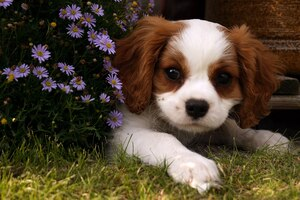

In [ ]:
# Image is Cute_dog.jpg from Wikimedia
fn = Path('samples/puppy.jpg')
display.Image(filename=fn, width=200)

In [ ]:
img = fn.read_bytes()

In [ ]:
#| exports
def _add_cache(d, cache):
    "Optionally add cache control"
    if cache: d["cache_control"] = {"type": "ephemeral"}
    return d

Claude supports context caching by adding a `cache_control` header, so we provide an option to enable that.

In [ ]:
#| exports
def img_msg(data:bytes, cache=False)->dict:
    "Convert image `data` into an encoded `dict`"
    img = base64.b64encode(data).decode("utf-8")
    mtype = mimetypes.types_map['.'+imghdr.what(None, h=data)]
    r = dict(type="base64", media_type=mtype, data=img)
    return _add_cache({"type": "image", "source": r}, cache)

Anthropic have documented the particular `dict` structure that expect image data to be in, so we have a little function to create that for us.

In [ ]:
#| exports
def text_msg(s:str, cache=False)->dict:
    "Convert `s` to a text message"
    return _add_cache({"type": "text", "text": s}, cache)

A Claude message can be a list of image and text parts. So we've also created a helper for making the text parts.

In [ ]:
q = "In brief, what color flowers are in this image?"
msg = mk_msg([img_msg(img), text_msg(q)])

In [ ]:
c([msg])

The image does not contain any flowers. It appears to be a photograph of a person.

<details>

- id: `msg_01SAtFPJeWcQkgeLkg2YfMCx`
- content: `[{'text': 'The image does not contain any flowers. It appears to be a photograph of a person.', 'type': 'text'}]`
- model: `claude-3-haiku-20240307`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 27574, 'output_tokens': 21, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

In [ ]:
#| exports
def _str_if_needed(o):
    if isinstance(o, (list,tuple,abc.Mapping,L)) or hasattr(o, '__pydantic_serializer__'): return o
    return str(o)

In [ ]:
#| exports
def _mk_content(src, cache=False):
    "Create appropriate content data structure based on type of content"
    if isinstance(src,str): return text_msg(src, cache=cache)
    if isinstance(src,bytes): return img_msg(src, cache=cache)
    if isinstance(src, abc.Mapping): return {k:_str_if_needed(v) for k,v in src.items()}
    return _str_if_needed(src)

There's not need to manually choose the type of message, since we figure that out from the data of the source data.

In [ ]:
_mk_content('Hi')

{'type': 'text', 'text': 'Hi'}

In [ ]:
#| exports
def mk_msg(content, # A string, list, or dict containing the contents of the message
           role='user', # Must be 'user' or 'assistant'
           cache=False,
           **kw):
    "Helper to create a `dict` appropriate for a Claude message. `kw` are added as key/value pairs to the message"
    if hasattr(content, 'content'): content,role = content.content,content.role
    if isinstance(content, abc.Mapping): content=content.get('content', content)
    if not isinstance(content, list): content=[content]
    content = [_mk_content(o, cache if islast else False) for islast,o in loop_last(content)] if content else '.'
    return dict2obj(dict(role=role, content=content, **kw), list_func=list)

In [ ]:
mk_msg(['hi', 'there'], cache=True)

```json
{ 'content': [{'type': 'text', 'text': 'hi'}, {'type': 'text', 'text': 'there', 'cache_control': {'type': 'ephemeral'}}],
  'role': 'user'}
```

In [ ]:
m = mk_msg(['hi', 'there'], cache=True)

When we construct a message, we now use `_mk_content` to create the appropriate parts. Since a dialog contains multiple messages, and a message can contain multiple content parts, to pass a single message with multiple parts we have to use a list containing a single list:

In [ ]:
c([[img, q]])

The image contains purple or lavender-colored flowers, which appear to be daisies or a similar type of flower.

<details>

- id: `msg_011HPybG8XBsr3RD5g1bCzQ4`
- content: `[{'text': 'The image contains purple or lavender-colored flowers, which appear to be daisies or a similar type of flower.', 'type': 'text'}]`
- model: `claude-3-haiku-20240307`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 110, 'output_tokens': 28, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

:::{.callout-note}

As promised (much!) earlier, we've now finally completed our definition of `mk_msg`, and this version is the one we export to the Python module.

:::

## Third party providers

### Amazon Bedrock

These are Amazon's current Claude models:

In [ ]:
models_aws

['anthropic.claude-3-opus-20240229-v1:0',
 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'anthropic.claude-3-sonnet-20240229-v1:0',
 'anthropic.claude-3-haiku-20240307-v1:0']

We don't need any extra code to support Amazon Bedrock -- we just have to set up the approach client:

In [ ]:
ab = AnthropicBedrock(
    aws_access_key=os.environ['AWS_ACCESS_KEY'],
    aws_secret_key=os.environ['AWS_SECRET_KEY'],
)
client = Client(models_aws[-1], ab)

In [ ]:
chat = Chat(cli=client)

In [ ]:
chat("I'm Jeremy")

Hello Jeremy! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to talk about or any questions you have?

<details>

- id: `msg_bdrk_01MwjVA5hwyfob3w4vdsqpnU`
- content: `[{'text': "Hello Jeremy! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to talk about or any questions you have?", 'type': 'text'}]`
- model: `claude-3-5-sonnet-20240620`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 10, 'output_tokens': 36}`

</details>

### Google Vertex

In [ ]:
models_goog

['claude-3-opus@20240229',
 'claude-3-5-sonnet@20240620',
 'claude-3-sonnet@20240229',
 'claude-3-haiku@20240307']

In [ ]:
from anthropic import AnthropicVertex
import google.auth

In [ ]:
project_id = google.auth.default()[1]
region = "us-east5"
gv = AnthropicVertex(project_id=project_id, region=region)
client = Client(models_goog[-1], gv)

In [ ]:
chat = Chat(cli=client)

In [ ]:
chat("I'm Jeremy")

Hello Jeremy! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to talk about or any questions you have?

<details>

- id: `msg_vrtx_01PFtHewPDe35yShy7vecp5q`
- content: `[{'text': "Hello Jeremy! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to talk about or any questions you have?", 'type': 'text'}]`
- model: `claude-3-5-sonnet-20240620`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 10, 'output_tokens': 36}`

</details>

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()